In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from scipy import ndimage as ndi
import skimage as skim
from skimage import feature
import pandas as pd
import xarray as xr
plt.rcParams['figure.figsize'] = (10,8)
import pickle as pkl

# Load mre data
full_data_dir = '/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE/'
ds = pkl.load(open(full_data_dir+'mre_ds_transform_2.p', 'rb'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
ds

<xarray.Dataset>
Dimensions:   (sequence: 10, slices: 4, subject: 20, x: 256, y: 256)
Coordinates:
  * subject   (subject) <U3 '365' '368' '370' '371' ... '403' '404' '405' '406'
  * sequence  (sequence) <U8 'T2SS' 'T1Pre' 'T1Pos' ... 'extra3' 'extra4'
Dimensions without coordinates: slices, x, y
Data variables:
    images    (subject, sequence, slices, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0
    ages      (subject) int64 58 60 58 74 73 64 38 76 ... 70 37 63 63 56 44 50

In [13]:
print(ds.sequence)
print(ds.subject[0])

<xarray.DataArray 'sequence' (sequence: 10)>
array(['T2SS', 'T1Pre', 'T1Pos', 'T2FR', 'elastMsk', 'elast', 'msk', 'extra2',
       'extra3', 'extra4'], dtype='<U8')
Coordinates:
  * sequence  (sequence) <U8 'T2SS' 'T1Pre' 'T1Pos' ... 'extra3' 'extra4'
<xarray.DataArray 'subject' ()>
array('365', dtype='<U3')
Coordinates:
    subject  <U3 '365'


In [25]:
def torch_ds_vis(torch_ds, index):
    fig, axes = plt.subplots(4, 4, constrained_layout=True, figsize=(10,10), sharex=True, sharey=True)
    for cols in axes:
        for cell in cols:
            axes[cols][cell].imshow(torch_ds[cols][cell])
    

In [15]:
# Use xArray to define the dataset.  Easy to query and map (although might not be fast when scaling up)
input_example = ds.sel(sequence=['T2SS', 'T1Pre', 'T1Pos', 'T2FR']).images
target_example = ds.sel(sequence=['elast']).images

In [20]:
input_example.values.shape

(20, 4, 4, 256, 256)

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

# need data to be ordered thusly:
# image_sequence,width,hight,depth
class MREDataset(Dataset):
    def __init__(self, xa_ds, set_type='train', transform=None):
        subjects = xa_ds.subject
        inputs = ['T2SS', 'T1Pre', 'T1Pos', 'T2FR']
        targets = ['elast']
        if set_type == 'train':
            subjects = subjects[:-2]
        elif set_type == 'val':
            subjects = subjects[-2:]
        else:
            raise AttributeError('Must choose one of ["train", "val"] for `set_type`.')
        #self.subject_dict = dict(zip(range(len(subjects), subjects )))
        
        self.input_images = xa_ds.sel(sequence=inputs, subject=subjects).transpose(
            'subject', 'sequence', 'x', 'y', 'slices').images.values
        self.target_images = xa_ds.sel(sequence=targets, subject=subjects).transpose(
            'subject', 'sequence', 'x', 'y', 'slices').images.values
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        target = self.target_images[idx]
        if self.transform:
            image = torch.Tensor(self.transform(image))
            target = torch.Tensor(self.transform(target))
        
        return [image, target]

# use same transform for train/val for this example
#trans = transforms.Compose([
#   torch.Tensor(),
#])
trans=None

train_set = MREDataset(ds, set_type='train', transform = trans)
val_set = MREDataset(ds, set_type='val', transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 1

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 18, 'val': 2}

In [36]:
import torchvision.utils

# Get a batch of training data
inputs, targets= next(iter(dataloaders['train']))

#print(inputs.shape, masks.shape)
#for x in [inputs.numpy(), masks.numpy()]:
#    print(x.min(), x.max(), x.mean(), x.std())
print(inputs.shape)

#torch_ds_vis(inputs)

torch.Size([1, 4, 256, 256, 4])


In [5]:
from torchsummary import summary
import torch
import torch.nn as nn
import pytorch_unet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = pytorch_unet.UNet(6)
model = model.to(device)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [6]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 6

model = pytorch_unet.UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

cuda:0
Epoch 0/39
----------
LR 0.0001


/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.227722, dice: 0.993783, loss: 0.610752
val: bce: 0.026737, dice: 0.969505, loss: 0.498121
saving best model
0m 43s
Epoch 1/39
----------
LR 0.0001
train: bce: 0.022401, dice: 0.789227, loss: 0.405814
val: bce: 0.026967, dice: 0.670523, loss: 0.348745
saving best model
0m 43s
Epoch 2/39
----------
LR 0.0001
train: bce: 0.026391, dice: 0.570979, loss: 0.298685
val: bce: 0.022720, dice: 0.458770, loss: 0.240745
saving best model
0m 43s
Epoch 3/39
----------
LR 0.0001
train: bce: 0.017827, dice: 0.413812, loss: 0.215819
val: bce: 0.014746, dice: 0.377296, loss: 0.196021
saving best model
0m 43s
Epoch 4/39
----------
LR 0.0001
train: bce: 0.012895, dice: 0.315185, loss: 0.164040
val: bce: 0.010348, dice: 0.237765, loss: 0.124057
saving best model
0m 43s
Epoch 5/39
----------
LR 0.0001
train: bce: 0.009704, dice: 0.222685, loss: 0.116194
val: bce: 0.008657, dice: 0.193178, loss: 0.100918
saving best model
0m 43s
Epoch 6/39
----------
LR 0.0001
train: bce: 0.009053, dice: 0.2102

/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


(3, 6, 192, 192)


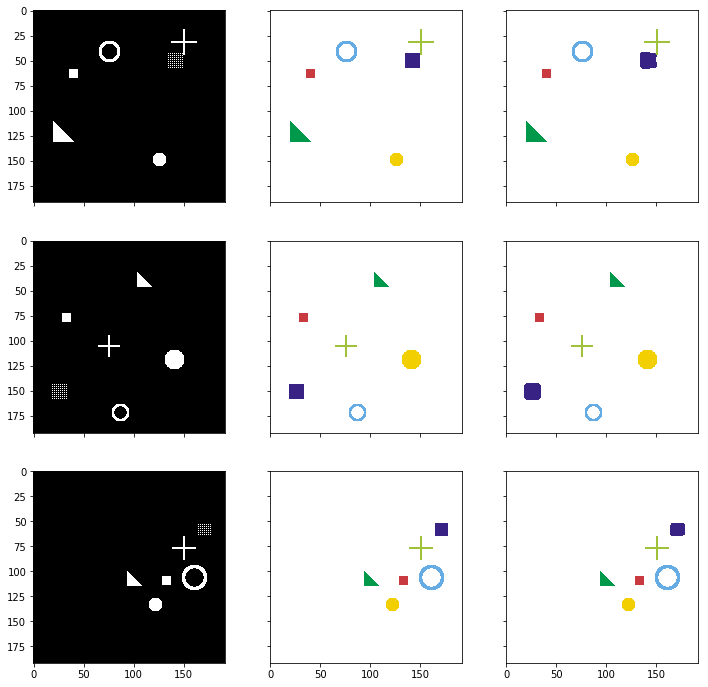

In [8]:
# prediction

import math

model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])